In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/arthur/code/deepdive
%matplotlib inline

/home/arthur/code/deepdive


In [2]:
import math
import time
import numpy as np
import random

import torch
import torch.nn as nn
import utils

import base.module as base

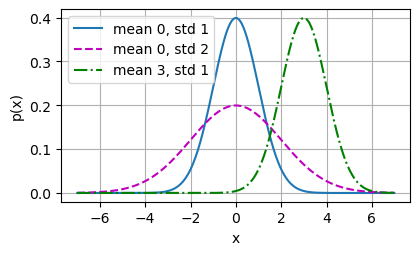

In [3]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
utils.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## Linear Regression from Scratch

In [4]:
class SyntheticRegressionData(base.DataModule):
    """Synthetic data for linear regression"""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, torch.reshape(w, (-1, 1))) + b + noise

In [5]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

[**Each row in `features` consists of a vector in $\mathbb{R}^2$ and each row in `labels` is a scalar.**]

In [6]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([-0.8159,  2.7106]) 
label: tensor([-6.6627])


In [7]:
@utils.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [8]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [9]:
@utils.add_to_class(base.DataModule)  
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

@utils.add_to_class(SyntheticRegressionData)  
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [10]:
len(data.train_dataloader())

32

In [11]:
class SGD(base.HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [12]:
class LinearRegressionScratch(base.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
    
    def forward(self, X):
        return torch.matmul(X, self.w) + self.b
    
    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()
    
    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)

In [13]:
@utils.add_to_class(base.Trainer)  
def prepare_batch(self, batch):
    return batch

@utils.add_to_class(base.Trainer)  
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

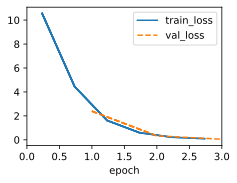

In [14]:
model = LinearRegressionScratch(2, lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = base.Trainer(max_epochs=3)
trainer.fit(model, data)

In [15]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1119, -0.1871])
error in estimating b: tensor([0.2253])


## Linear Regression Consise Implementation

In [16]:
class LinearRegression(base.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

    def forward(self, X):
        return self.net(X)
    
    def loss(self, y_hat, y):
        fn = nn.MSELoss()
        return fn(y_hat, y)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)
    
    def get_w_b(self):
        return (self.net.weight.data, self.net.bias.data)

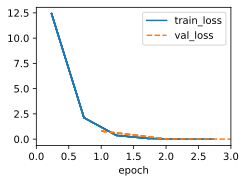

In [17]:
model = LinearRegression(lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = base.Trainer(max_epochs=3)
trainer.fit(model, data)

In [18]:
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0164, -0.0143])
error in estimating b: tensor([0.0174])


## High-Dimensional Linear Regression

In [19]:
class Data(base.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [20]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [22]:
class WeightDecayScratch(LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [23]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = base.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.010708619840443134


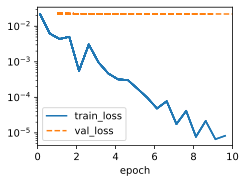

In [24]:
# lambd = 0, disabling weight decay - overfitting
train_scratch(0)

L2 norm of w: 0.0016711653443053365


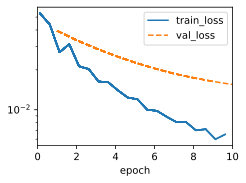

In [25]:
# regularization
train_scratch(3)

## Weight Decay Regression Concise Implementation